In [1]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.stats import bernoulli, norm, poisson
from scipy import stats
import seaborn as sns
from sklearn.linear_model import LinearRegression
from statistics import mean
import math

# Construct the model

$$X_1 \sim \mathcal{N}(0,\sigma^2)$$
$$Y= \beta_1 X_1+\varepsilon_y$$
$$X_2=\beta_2Y+\varepsilon_2$$
$$\varepsilon_2 \sim \mathcal{N}(0,1)$$
$$\varepsilon_y \sim \mathcal{N}(0,\sigma^2)$$

The joint distribution is
$$\tilde{P}^{\sigma}(dX_1,dX_2,dY)=P(dX_1)Q_{X_1}(dX_2)Q_{X_1}^{\sigma}(dy)$$ 

The linear regression predictor is an equivariant predictor.

The invariant loss function is $$MSE=\frac{1}{2}\sum_{i=1}^{n}(y-\hat{y})^2$$
The risk function is 
$$r(\hat{y})=\int_{\mathcal{X}\times \mathcal{Y}}L(y,\hat{y})dP(x  ,y)$$

The three predictive models are
$$\left\{\begin{aligned} &\ell_1: \hat{y}=\hat{\beta}_0+\hat{\beta}_1x_1\\&\ell_2: \hat{y}=\hat{\alpha}_0+\hat{\alpha}_1x_2\\&\ell_3:\hat{y}=\hat{\gamma}_0+\hat{\gamma}_1x_1+\hat{\gamma}_2x_2\end{aligned}\right.$$ 

## Compute the estimated coefficients with X1, X2 and (X1, X2)

In [2]:
#Define a function of simulating coefficients for y_hat=beta_1_hat x1 +beta_0_hat
def coef_1(n,sigma,g1,beta1,beta2):
    X1=np.random.normal(0, sigma, n)+g1 # do intervention on X1 in environment 1
    Y=beta1*X1+np.random.normal(0,sigma, n)
    X2=beta2*Y+np.random.normal(0, 1, n)
    X=np.hstack([X1.reshape(-1,1)])
    y=np.hstack([Y.reshape(-1,1)])
    reg=LinearRegression().fit(X, y)  #fit linear regression with only X1
    return np.append(reg.coef_,reg.intercept_)

In [3]:
#Define a function of simulating coefficients for y_hat=alpha_1_hat x1 +alpha_0_hat
def coef_2(n,sigma,g2,beta1,beta2):
    X1=np.random.normal(0, sigma, n)
    Y=beta1*X1+np.random.normal(0,sigma, n)
    X2=beta2*Y+np.random.normal(0, 1, n)+g2 #do intervention on X2 in environment 1(for X2)
    X=np.hstack([X2.reshape(-1,1)]) 
    y=np.hstack([Y.reshape(-1,1)])
    reg=LinearRegression().fit(X, y)  #fit the linear regression with only X2
    return np.append(reg.coef_,reg.intercept_)

In [4]:
#Define coefficient function for y_hat=gamma_1_hat x1 +gamma_2_hat x2+ gamma_0_hat
def coef_12(n,sigma,g1,g2,beta1,beta2):
    X1=np.random.normal(0, sigma, n)+g1 #intervention on X1 in environment 1(for X1)
    Y=beta1*X1+np.random.normal(0,sigma, n)
    X2=beta2*Y+np.random.normal(0, 1, n)+g2 #intervention on X2 in environment 1(for X2)
    X=np.hstack([X1.reshape(-1,1),X2.reshape(-1,1)])
    y=np.hstack([Y.reshape(-1,1)])
    reg=LinearRegression().fit(X, y)#fit the linear regression with X1 and X2
    return np.append(reg.coef_,reg.intercept_)

## Shift X1

In [5]:
# Define the risk function of three predictive models shifting X1
def risk_function1_same(n1,n2,sigma,x,iterate,g1,g2,beta1,beta2):
    # n1: sample size for simulating coefficients
    # n2: sample size for simulating variables
    # x: a matrix of shifting values in x1 and x2
    list1=[]
    list2=[]
    list12=[]
    for i in range(1,iterate):
        X1=np.random.normal(0, sigma, n2)+x[0]
        Y=beta1*X1+np.random.normal(0,sigma, n2)
        X2=beta2*Y+np.random.normal(0, 1, n2)
        X=np.hstack([X1.reshape(-1,1)])
        pred_1=X1*coef_1(n1,sigma,g1,beta1,beta2)[0]+coef_1(n1,sigma,g1,beta1,beta2)[1]
        pred_2=X2*coef_2(n1,sigma,g2,beta1,beta2)[0]+coef_2(n1,sigma,g2,beta1,beta2)[1]
        pred_12=X1*coef_12(n1,sigma,g1,g2,beta1,beta2)[0]+X2*coef_12(n1,sigma,g1,g2,beta1,beta2)[1]+coef_12(n1,sigma,g1,g2,beta1,beta2)[2]
        #use the simulated coefficients
        list1.append(0.5*sum((Y-pred_1)**2)) 
        list2.append(0.5*sum((Y-pred_2)**2)) 
        list12.append(0.5*sum((Y-pred_12)**2))
        l=np.append(sum(list1)/(iterate),sum(list2)/(iterate)) # list of risks
    return np.append(l,sum(list12)/(iterate))

In [6]:
# Define the plot function of the risk function shifting X1
def shift_same_X1(beta1,beta2,n):
    a=np.linspace(0., 20., 30)
    b=np.linspace(0., 20., 30)
    m=np.hstack([a.reshape(-1,1),b.reshape(-1,1)])
    matrix=risk_function1_same(n,100,1,m[0],100,0,0,beta1,beta2)
   
    for i in range(1,30):
        matrix=np.column_stack((matrix,risk_function1_same(n,100,1,m[i],100,0,0,beta1,beta2)))
        
    list1=(matrix[0])
    
    list2=(matrix[1])
    list3=(matrix[2])

    plt.figure(figsize=(10,7))

    N = 30
    plt.rcParams['text.usetex'] = True

    colors = np.random.rand(N)
    area = (30 * 0.5)**2 
    plt.scatter(np.linspace(0., 20., 30), list1, s=area, alpha=0.5)
    plt.scatter(np.linspace(0., 20., 30), list2, s=area, alpha=0.5)
    plt.scatter(np.linspace(0., 20., 30), list3, s=area, alpha=0.5)
    classes = [ r'predict with $X_1$',r'predict with $X_2$',r'predict with $X_1$ and $X_2$']
    plt.legend(labels=classes)
    plt.xlabel(r'Shifting value ($g_1=g_2$)',fontsize=30)
    plt.ylabel("Risks",fontsize=30)

    #plt.legend(loc='best')
    message = f"Risk function of shifting $X_1$, $\\beta_1$={beta1}, $\\beta_2$={beta2}"
    plt.title(message,fontsize=30) 
    plt.show() 

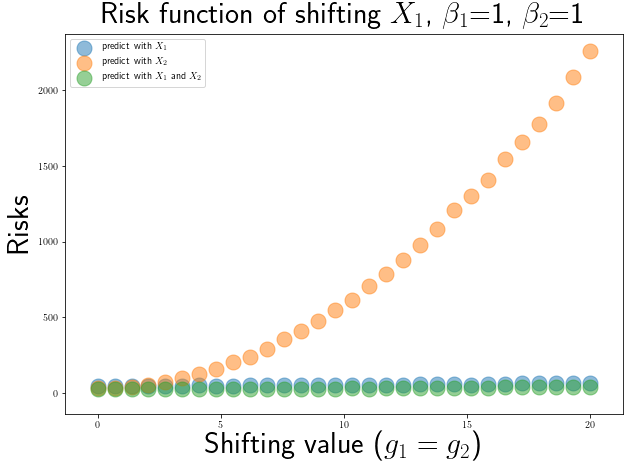

In [7]:
shift_same_X1(1,1,1000)

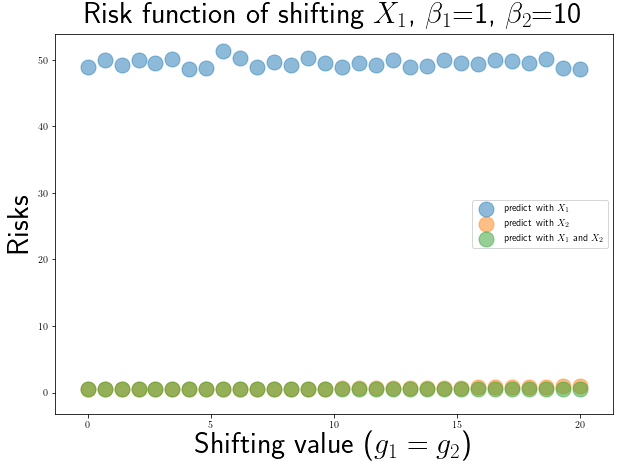

In [8]:
shift_same_X1(1,10,100000)

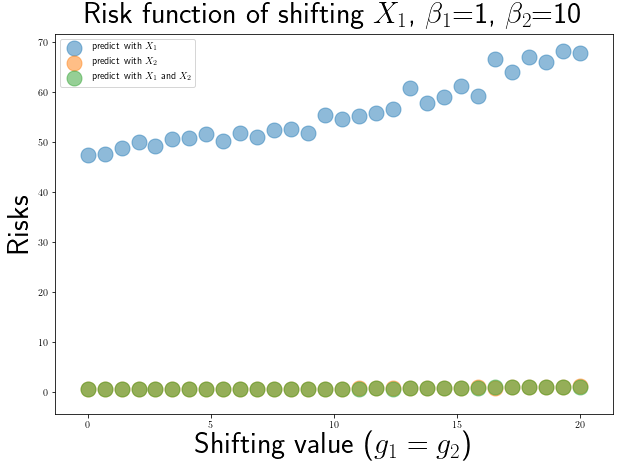

In [9]:
shift_same_X1(1,10,1000)

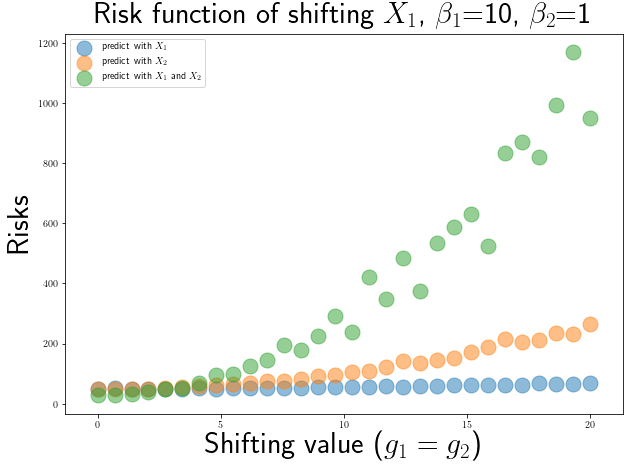

In [10]:
shift_same_X1(10,1,1000)

### sample size =1000 vs sample size=100000

In [11]:
def shift_same_X1_subset(beta1,beta2,n1,n2):
    a=np.linspace(0., 20., 30)
    b=np.linspace(0., 20., 30)
    m=np.hstack([a.reshape(-1,1),b.reshape(-1,1)])
    matrix1=risk_function1_same(n1,100,1,m[0],100,0,0,beta1,beta2)
    matrix2=risk_function1_same(n2,100,1,m[0],100,0,0,beta1,beta2)
   
    for i in range(1,30):
        matrix1=np.column_stack((matrix1,risk_function1_same(n1,100,1,m[i],100,0,0,beta1,beta2)))
        matrix2=np.column_stack((matrix2,risk_function1_same(n2,100,1,m[i],100,0,0,beta1,beta2)))
        
    list1=(matrix1[0])
    list2=(matrix2[0])
    
    

    plt.figure(figsize=(10,7))

    N = 30

    colors = np.random.rand(N)
    area = (30 * 0.5)**2 
    plt.scatter(np.linspace(0., 20., 30), list1, s=area, alpha=0.5)
    plt.scatter(np.linspace(0., 20., 30), list2, s=area, alpha=0.5)
    #plt.scatter(np.linspace(0., 20., 30), list2, s=area, alpha=0.5)
    #plt.scatter(np.linspace(0., 20., 30), list3, s=area, alpha=0.5)
    classes = [ 'sample size=1000','sample size=100000']
    plt.legend(labels=classes)
    plt.xlabel(r'Shifting value ($g_1=g_2$)',fontsize=30)
    plt.ylabel("Risks",fontsize=30)
    #plt.ylim([45, 75])

    #plt.legend(loc='best')
    message = message = f"Risk function of predicting with $X_1$, shifting $X_1$, $\\beta_1$={beta1}, $\\beta_2$={beta2}"
    plt.title(message,fontsize=25) 
    plt.show() 

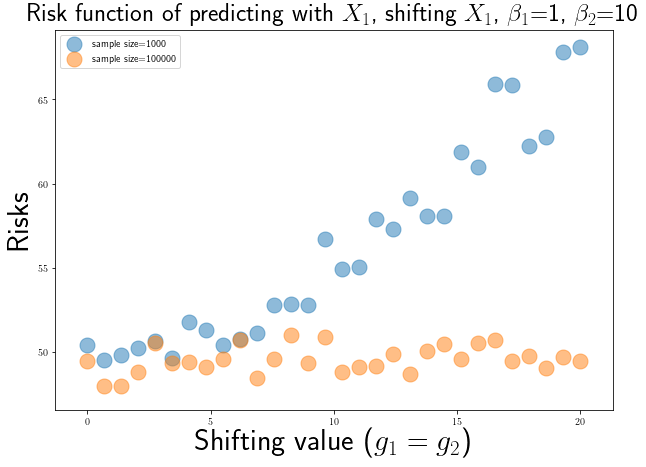

In [12]:
shift_same_X1_subset(1,10,1000,100000)

## Use same y and shift X2

In [13]:
# Define the risk function of three predictive models shifting X2
def risk_function2_same(n1,n2,sigma,x,iterate,g1,g2,beta1,beta2):
    # n1: sample size for simulating coefficients
    # n2: sample size for simulating variables
    # x: a matrix of shifting values in x1 and x2
    list1=[]
    list2=[]
    list12=[]
    for i in range(1,iterate):
        X1=np.random.normal(0, sigma, n2) 
        Y=beta1*X1+np.random.normal(0,sigma, n2)
        X2=beta2*Y+np.random.normal(0, 1, n2)+x[1]
        pred_1=X1*coef_1(n1,sigma,g1,beta1,beta2)[0]+coef_1(n1,sigma,g1,beta1,beta2)[1]
        pred_2=X2*coef_2(n1,sigma,g2,beta1,beta2)[0]+coef_2(n1,sigma,g2,beta1,beta2)[1]
        pred_12=X1*coef_12(n1,sigma,g1,g2,beta1,beta2)[0]+X2*coef_12(n1,sigma,g1,g2,beta1,beta2)[1]+coef_12(n1,sigma,g1,g2,beta1,beta2)[2]
        #use the simulated coefficients
        list1.append(0.5*sum((Y-pred_1)**2)) 
        list2.append(0.5*sum((Y-pred_2)**2)) 
        list12.append(0.5*sum((Y-pred_12)**2))
        l=np.append(sum(list1)/(iterate),sum(list2)/(iterate)) # list of risk function
    return np.append(l,sum(list12)/(iterate))

In [14]:
# Define the plot function of the risk function shifting X2
def shift_same_X2(beta1,beta2,n):
    a=np.linspace(0., 20., 30)
    b=np.linspace(0., 20., 30)
    list1=[]
    list2=[]
    list3=[]
    m=np.hstack([a.reshape(-1,1),b.reshape(-1,1)])
    matrix=risk_function2_same(n,100,1,m[0],100,0,0,beta1,beta2)


   
    for i in range(1,30):
        matrix=np.column_stack((matrix,risk_function2_same(n,100,1,m[i],100,0,0,beta1,beta2)))
        
    list1=(matrix[0])
    list2=(matrix[1])
    list3=(matrix[2])



    

    plt.figure(figsize=(10,7))

    N = 30

    colors = np.random.rand(N)
    area = (30 * 0.5)**2 
    plt.scatter(np.linspace(0., 20., 30), list1, s=area, alpha=0.5)
    plt.scatter(np.linspace(0., 20., 30), list2, s=area, alpha=0.5)
    plt.scatter(np.linspace(0., 20., 30), list3, s=area, alpha=0.5)
    classes = [r'predicted with $X_1$', r'predicted with $X_2$',r'predicted with $X_1$ and $X_2$']
    plt.legend(labels=classes)
    plt.xlabel(r"Shifting value ($g_1=g_2$)",fontsize=30)
    plt.ylabel("Risks",fontsize=30)

    message = f"Risk function of shifting $X_2$, $\\beta_1$={beta1}, $\\beta_2$={beta2}"
    plt.title(message,fontsize=30) 
    plt.show() 

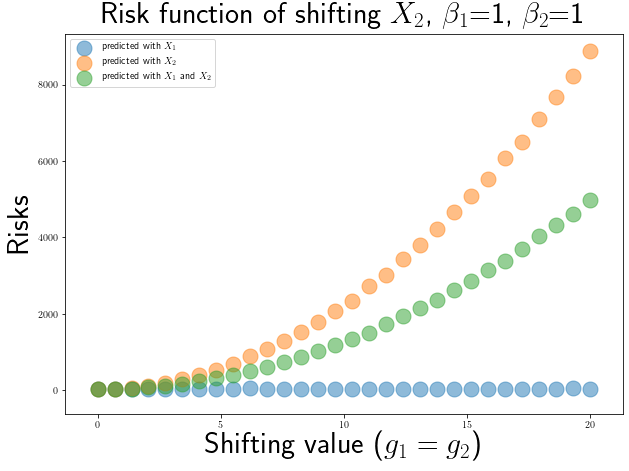

In [15]:
shift_same_X2(1,1,1000)

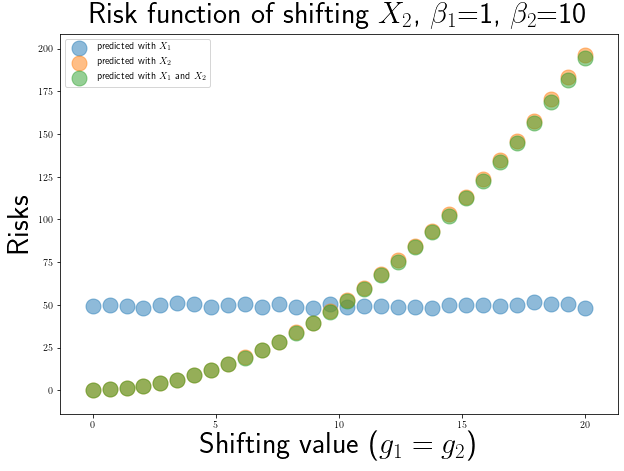

In [16]:
shift_same_X2(1,10,1000)

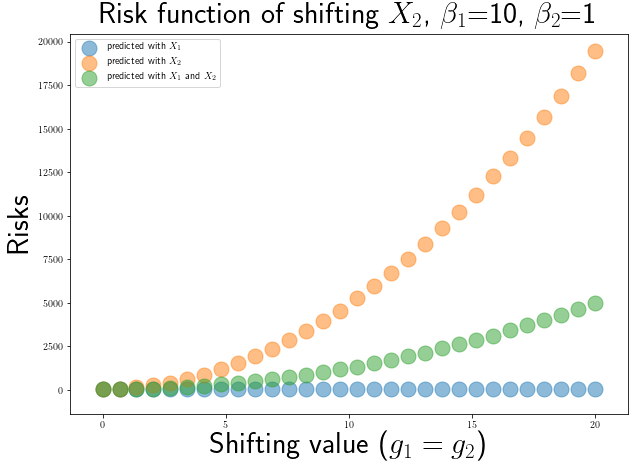

In [17]:
shift_same_X2(10,1,1000)

## Shift X1 and X2

In [18]:
# Define the risk function of three predictive models shifting X1 and X2
def risk_function12_same(n1,n2,sigma,x,iterate,g1,g2,beta1,beta2):
    # n1: sample size for simulating coefficients
    # n2: sample size for simulating variables
    # x: a matrix of shifting values in x1 and x2
    list1=[]
    list2=[]
    list12=[]
    for i in range(1,iterate):
        X1=np.random.normal(0, sigma, n2)+x[0]
        Y=beta1*X1+np.random.normal(0,sigma, n2)
        X2=beta2*Y+np.random.normal(0, 1, n2)+x[1]
        pred_1=X1*coef_1(n1,sigma,g1,beta1,beta2)[0]+coef_1(n1,sigma,g1,beta1,beta2)[1]
        pred_2=X2*coef_2(n1,sigma,g2,beta1,beta2)[0]+coef_2(n1,sigma,g2,beta1,beta2)[1]
        pred_12=X1*coef_12(n1,sigma,g1,g2,beta1,beta2)[0]+X2*coef_12(n1,sigma,g1,g2,beta1,beta2)[1]+coef_12(n1,sigma,g1,g2,beta1,beta2)[2]
        #use the simulated coefficients
        list1.append(0.5*sum((Y-pred_1)**2)) 
        list2.append(0.5*sum((Y-pred_2)**2)) 
        list12.append(0.5*sum((Y-pred_12)**2))
        l=np.append(sum(list1)/(iterate),sum(list2)/(iterate))
    return np.append(l,sum(list12)/(iterate))

In [19]:
# Define the plot function of the risk function shifting X1 and X2
def shift_same_X12(beta1,beta2,n):
    a=np.linspace(0., 20., 30)
    b=np.linspace(0., 20., 30)
    list1=[]
    list2=[]
    list3=[]
    m=np.hstack([a.reshape(-1,1),b.reshape(-1,1)])
    matrix=risk_function12_same(n,100,1,m[0],100,0,0,beta1,beta2)


   
    for i in range(1,30):
        matrix=np.column_stack((matrix,risk_function12_same(n,100,1,m[i],100,0,0,beta1,beta2)))
        
    list1=(matrix[0])
    list2=(matrix[1])
    list3=(matrix[2])

    

    plt.figure(figsize=(10,7))

    N = 30

    colors = np.random.rand(N)
    area = (30 * 0.5)**2 
    plt.scatter(np.linspace(0., 20., 30), list1, s=area, alpha=0.5)
    plt.scatter(np.linspace(0., 20., 30), list2, s=area, alpha=0.5)
    plt.scatter(np.linspace(0., 20., 30), list3, s=area, alpha=0.5)
    classes = [r'predicted with $X_1$', r'predicted with $X_2$',r'predicted with $X_1$ and $X_2$']
    plt.legend(labels=classes)
    plt.xlabel(r"Shifting value ($g_1=g_2$)",fontsize=30)
    plt.ylabel("Risks",fontsize=30)

    message = f"Risk function of shifting $X_1$ and $X_2$, $\\beta_1$={beta1}, $\\beta_2$={beta2}"
    plt.title(message,fontsize=30) 
    plt.show() 

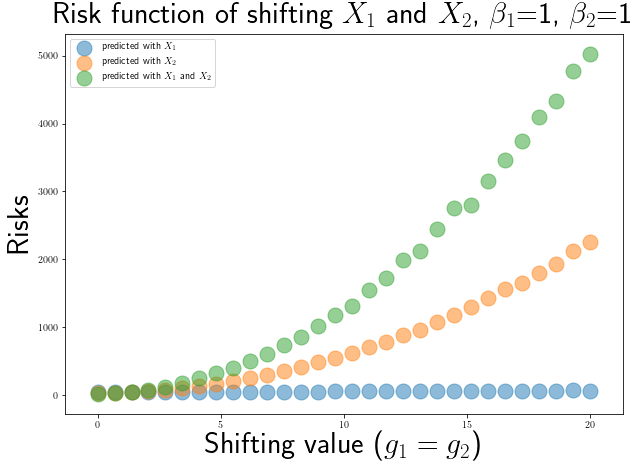

In [20]:
shift_same_X12(1,1,1000)

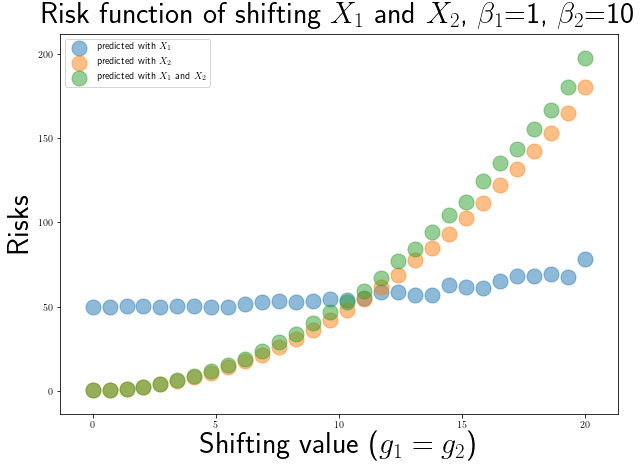

In [21]:
shift_same_X12(1,10,1000)

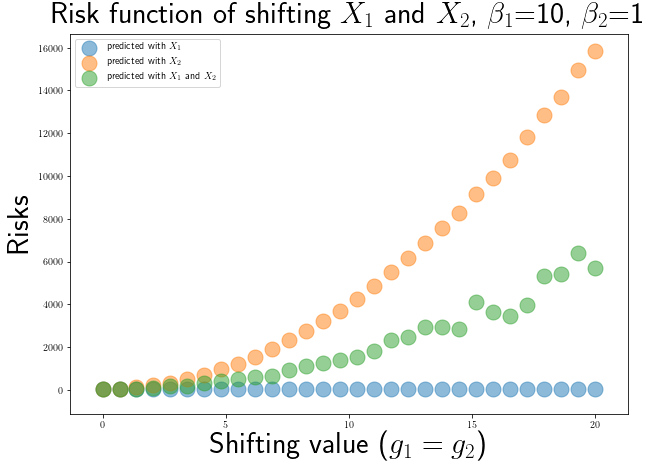

In [22]:
shift_same_X12(10,1,1000)